In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.tools.jupyter import *
from qiskit import IBMQ, execute
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.pulse import library as pulse_lib
from qiskit.tools.monitor import job_monitor


In [2]:
provider = IBMQ.load_account()
backend = provider.get_backend("ibmq_armonk")
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [3]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

backend_defaults = backend.defaults()

Sampling time: 0.2222222222222222 ns


In [4]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds
# We will find the qubit frequency for the following qubit.
qubit = 0
# We will define memory slot channel 0.
mem_slot = 0

In [5]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of_16(sec/dt)

In [6]:
# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

Qubit 0 has an estimated frequency of 4.971683004356552 GHz.


In [7]:
pulse_duration = get_dt_from(0.5 * us)
pulse_amp = 0.5 # max 1.
num_shots = 1024

In [8]:
with pulse.build(backend=backend, default_alignment="sequential", name="base_schedule") as schedule:
    pulse.set_frequency(center_frequency_Hz, pulse.drive_channel(qubit))
    pulse.play(
        pulse_lib.Constant(
            duration=pulse_duration,
            amp=pulse_amp,
            name="rect_pulse"
        ),
        pulse.drive_channel(qubit)
    )
    pulse.measure(
        qubits=[qubit],
        registers=[pulse.MemorySlot(mem_slot)]
    )

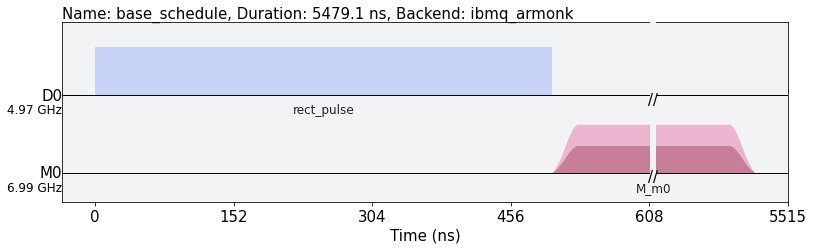

In [9]:
base_schedule = schedule.assign_parameters(
    {},
    inplace=False
)
base_schedule.draw(backend=backend)

In [10]:
job = execute(
    base_schedule,
    backend=backend,
    meas_level=2,
    meas_return='avg',
    memory=True,
    shots=num_shots
)
job_monitor(job)


Job Status: job has successfully run


In [11]:
result = job.result()

In [12]:
transition_probability = result.get_counts(0)["1"] / num_shots

In [13]:
job_id = job.job_id()
print("JobID:", job_id)

JobID: 6298688be9eab5ff20ba8fbb


In [14]:
print("transition_probability =", transition_probability)

transition_probability = 0.6357421875


In [15]:
result.get_counts(0)["1"]

651